<h1>This is the individual model:Simple_model_1Individual test,. Categorical!!!</h1>
<h1>Completed</h1>

In [1]:
import os
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization,Activation, concatenate, DepthwiseConv2D, Multiply,Dropout
from keras.layers import GlobalAveragePooling2D, Dense, MaxPooling2D,Flatten, Layer,BatchNormalization, Add,Reshape,AveragePooling2D

from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt



In [2]:
input_shape = (224, 224, 3)

train_dir = '/root/DRD_Split_Cloud/DRD_Split/train'
test_dir = '/root/DRD_Split_Cloud/DRD_Split/test'
batch_size = 8
num_classes = 2
# filter_factor = 8

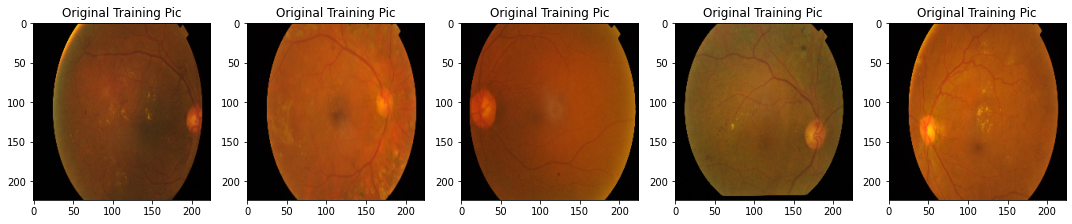

In [3]:
train_diabetic = '/root/DRD_Split_Cloud/DRD_Split/train/diabetic'

#Show the import original image
train_img_files = os.listdir(train_diabetic)
# test_img_files = os.listdir(test_dir)
# val_img_files = os.listdir(val_dir)

show_num = 5

plt.figure(figsize = (15, 5))

for i in range(show_num):
    
    img_path = os.path.join(train_diabetic, train_img_files[i])
    img = plt.imread(img_path)
    plt.subplot(1, show_num, i + 1)
    plt.imshow(img)
    plt.axis('on')
    plt.title("Original Training Pic")
    
plt.tight_layout()
plt.show()


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.13,  # Specify the validation split here
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the training and testing images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use 'training' subset for training data
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use 'validation' subset for validation data
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)




Found 2708 images belonging to 2 classes.
Found 404 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


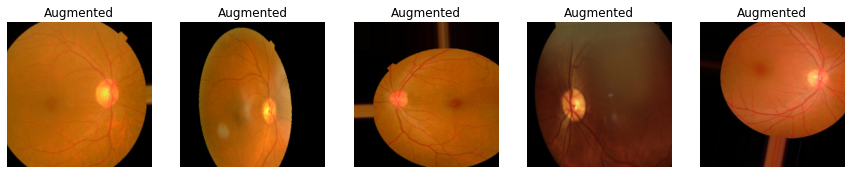

In [5]:
#To show the augmented pictures, after rotation, zoom in, rescale etc

# Extract a batch of images from the train_generator
sample_images, sample_labels = next(train_generator)

plt.figure(figsize = (15, 5))

# Show the original images from the batch
num_images_to_show = 5  # Show three images
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(sample_images[i-1])
    plt.title("Augmented")
    plt.axis('off')

In [6]:
def attention_block_2(x):
    # 使用卷积层创建一个更复杂的注意力机制
    attention_network = Conv2D(96, (3, 3), padding='same')(x)  # 增加卷积层
    attention_network = Activation('relu')(attention_network)
    attention_network = Conv2D(1, (1, 1), padding='same')(attention_network)  # 生成注意力图
    
    attention_output = Activation('sigmoid')(attention_network)
    scaled_feature = Multiply()([x, attention_output])  # 将注意力图应用于原始特征

    return scaled_feature

def simple_model_1(input_shape):
    inputs = Input(shape = input_shape)
    #Input convolution
    x = Conv2D(64, (3, 3), activation = 'leaky_relu',
               padding = 'same',kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = attention_block_2(x)
    x = MaxPooling2D(2, 2)(x)
    
    #First Dethwise Convolution
    x = Conv2D(64, (3, 3),  
               padding = 'same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = attention_block_2(x)
    x = MaxPooling2D(2, 2)(x)

    
    #Second convolutional layer
    x = Conv2D(32, (3, 3), 
               padding = 'same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = attention_block_2(x)
    x = MaxPooling2D(2, 2)(x)
    
    
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation = 'softmax')(x)
    model_1 = Model(inputs, outputs)
    
    return model_1


simple_model_1 = simple_model_1(input_shape)



simple_model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

2023-12-09 21:41:58.305120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 21:41:58.791993: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22307 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6


In [7]:
lr = 0.001
Optimizer = Adam(learning_rate = lr)

from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow_addons.metrics import F1Score

simple_model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy', 
        Precision(), 
        Recall(), 
        AUC(), 
        F1Score(num_classes=2, average = 'micro')
    ]
)
lr_reduction = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,
                                patience = 10,
                                min_lr = 0.00001,
                                verbose = 1)



In [8]:
history = simple_model_1.fit(train_generator, epochs = 100, validation_data=(validation_generator), callbacks = [lr_reduction])

Epoch 1/100


2023-12-09 21:42:01.941442: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-09 21:42:03.418509: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


339/339 [==============================] - 34s 90ms/step - loss: 0.4615 - accuracy: 0.7840 - precision: 0.7840 - recall: 0.7840 - auc: 0.8727 - f1_score: 0.7840 - val_loss: 1.3751 - val_accuracy: 0.5099 - val_precision: 0.5099 - val_recall: 0.5099 - val_auc: 0.5368 - val_f1_score: 0.5099 - lr: 0.0010
Epoch 2/100
339/339 [==============================] - 30s 89ms/step - loss: 0.3610 - accuracy: 0.8567 - precision: 0.8567 - recall: 0.8567 - auc: 0.9215 - f1_score: 0.8567 - val_loss: 0.2446 - val_accuracy: 0.9035 - val_precision: 0.9035 - val_recall: 0.9035 - val_auc: 0.9666 - val_f1_score: 0.9035 - lr: 0.0010
Epoch 3/100
339/339 [==============================] - 30s 87ms/step - loss: 0.3380 - accuracy: 0.8711 - precision: 0.8711 - recall: 0.8711 - auc: 0.9330 - f1_score: 0.8711 - val_loss: 0.6587 - val_accuracy: 0.5941 - val_precision: 0.5941 - val_recall: 0.5941 - val_auc: 0.7031 - val_f1_score: 0.5941 - lr: 0.0010
Epoch 4/100
339/339 [==============================] - 29s 87ms/step -

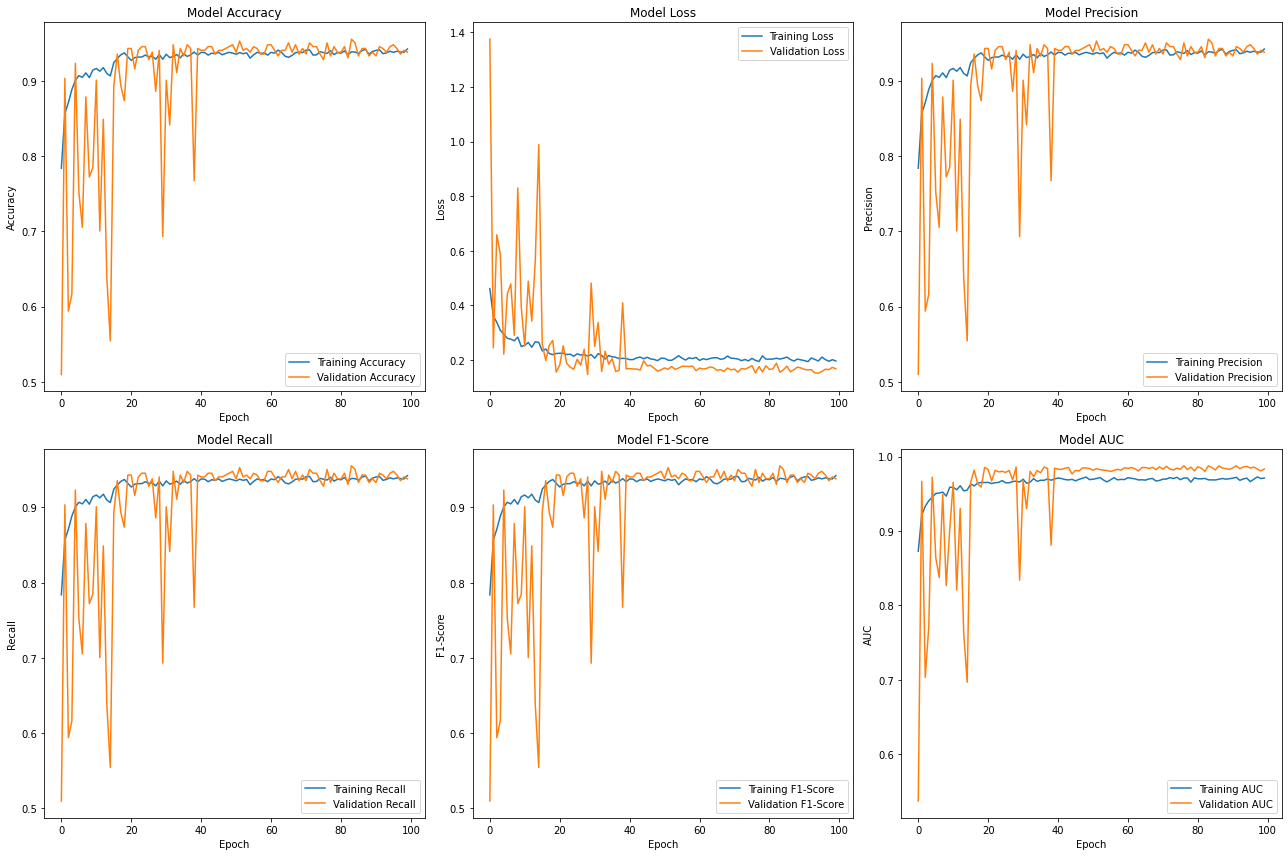

In [10]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')

plt.subplot(2, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

plt.subplot(2, 3, 3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training Precision', 'Validation Precision'], loc='lower right')


plt.subplot(2, 3, 4)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Training Recall', 'Validation Recall'], loc='lower right')

plt.subplot(2, 3, 5)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend(['Training F1-Score', 'Validation F1-Score'], loc='lower right')

plt.subplot(2, 3, 6)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training AUC', 'Validation AUC'], loc='lower right')

plt.tight_layout()
plt.show()

17/17 [==============================] - 1s 22ms/step


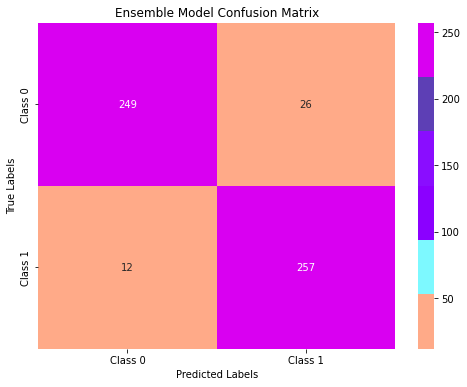

In [11]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Initialize lists to collect images and true labels
collected_images = []
collected_true_labels = []

# Use a traditional for loop to collect images and labels
for _ in range(test_generator.samples // test_generator.batch_size):
    images, true_labels = next(test_generator)
    collected_images.append(images)
    collected_true_labels.append(true_labels)

# Concatenate the lists of images and labels
collected_images = np.concatenate(collected_images)
collected_true_labels = np.argmax(np.concatenate(collected_true_labels), axis=1)

# Make predictions and get predicted labels
ensemble_predictions = simple_model_1.predict(collected_images)
ensemble_predicted_labels = np.argmax(ensemble_predictions, axis=1)

# Generate and plot confusion matrix
ensemble_conf_matrix = confusion_matrix(collected_true_labels, ensemble_predicted_labels)
plt.figure(figsize=(8, 6))

#customizae color
amethyst_palette = sns.color_palette([
    "#FFAA88",  
    "#7DF9FF",  
    "#8B00FF",  
    "#8A0DFF",  
    "#5D3FB5",  
    "#D900F1"   
])
sns.heatmap(ensemble_conf_matrix, 
            annot=True, 
            fmt="d", 
            cmap=amethyst_palette, 
            xticklabels=["Class 0", "Class 1"], 
            yticklabels=["Class 0", "Class 1"])

plt.title("Ensemble Model Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


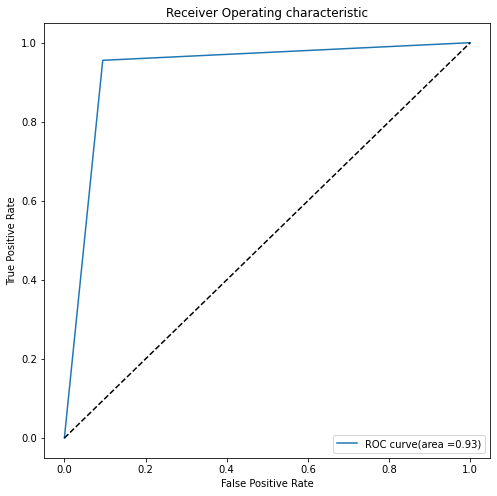

In [12]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(collected_true_labels, ensemble_predicted_labels)

#compute the AUC score
roc_auc= auc(fpr, tpr)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [13]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate 
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)



sensitivity: 0.9553903345724907
specificity: 0.9054545454545455


17/17 [==============================] - 0s 22ms/step


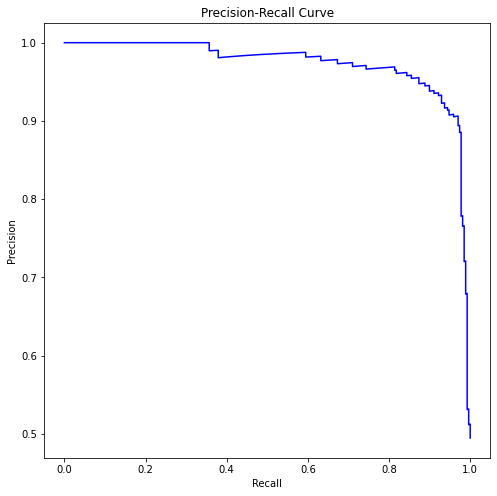

In [14]:
from sklearn.metrics import precision_recall_curve

# 计算预测概率
ensemble_pred_probs = simple_model_1.predict(collected_images)

# 获取预测正类的概率
# 假设是二分类问题，并且正类是第二个类别
positive_class_probs = ensemble_pred_probs[:, 1]

# 计算 Precision 和 Recall
precision, recall, thresholds = precision_recall_curve(collected_true_labels, positive_class_probs)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [15]:
from sklearn.metrics import classification_report
# 使用模型对验证集进行预测，获取预测概率
y_pred_probs = simple_model_1.predict(collected_images)

# 将预测概率转换为类别标签
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# 假设 y_val 是真实标签，并且也是类别标签形式
# 现在您可以生成分类报告
report = classification_report(collected_true_labels, y_pred_labels)
print(report)

17/17 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       275
           1       0.91      0.96      0.93       269

    accuracy                           0.93       544
   macro avg       0.93      0.93      0.93       544
weighted avg       0.93      0.93      0.93       544



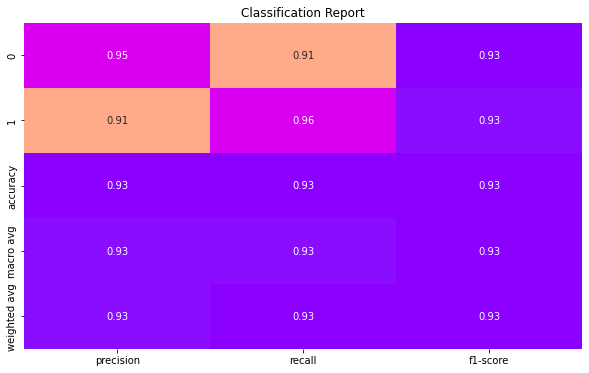

In [16]:
import pandas as pd



# 生成分类报告
report = classification_report(collected_true_labels, y_pred_labels, output_dict=True)

# 转换为 DataFrame
report_df = pd.DataFrame(report).transpose()

# 删除支持列，因为它不适合于热力图
report_df = report_df.drop(columns=['support'])

# 绘制热力图
plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap=amethyst_palette, cbar=False)
plt.title("Classification Report")
plt.show()


In [17]:
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1_score = simple_model_1.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test AUC:', test_auc)
print('Test F1 Score:', test_f1_score)

69/69 [==============================] - 1s 20ms/step - loss: 0.1929 - accuracy: 0.9309 - precision: 0.9309 - recall: 0.9309 - auc: 0.9742 - f1_score: 0.9309
Test loss: 0.19294346868991852
Test accuracy: 0.9309090971946716
Test precision: 0.9309090971946716
Test recall: 0.9309090971946716
Test AUC: 0.974168598651886
Test F1 Score: 0.9309090971946716


In [18]:
#delete the model to prevent memory costs

from keras import backend as K
import gc

K.clear_session()
gc.collect()

del simple_model_1


from numba import cuda

cuda.select_device(0)
cuda.close()